In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pint.simulation as ps
import pint.models as models
import pint.residuals as pr
import astropy
import astropy.units as u
from astropy.visualization import quantity_support

import scipy
from scipy.linalg import cho_solve,cho_factor,solve_triangular,LinAlgError

import pint.logging
from loguru import logger as log

pint.logging.setup(level='INFO')

1

In [2]:
# model = models.get_model('1231.par')
# toas = ps.make_fake_toas_uniform(55000,60000,1000,model)

In [3]:
# mjds = toas.get_mjds()
# residuals = pr.Residuals(toas,model)
# plt.plot(mjds,residuals.time_resids,'+')

In [4]:
# ps.zero_residuals(toas,model)
# phases = model.phase(toas).frac
# plt.hist(phases,bins=50)

In [5]:
# toas.adjust_TOAs(astropy.time.TimeDelta((np.random.normal(0.1,0.5,(1000,))*u.ms)))
# residuals = pr.Residuals(toas,model)
# plt.plot(mjds,residuals.time_resids,'+')

In [6]:
# phases = model.phase(toas).frac

In [7]:
# mean_phase = np.mean(phases)
# stdev_phase = np.std(phases)
# likelihood = scipy.stats.norm.pdf(phases,loc=mean_phase,scale=stdev_phase)

In [8]:
# lnlikelihood = np.log(likelihood)

In [9]:
# plt.hist(phases,bins=100)
# plt.axvline(phases[lnlikelihood == np.max(lnlikelihood)],linestyle='--',color='r')
# print(phases[lnlikelihood == np.max(lnlikelihood)])

In [10]:
# plt.plot(lnlikelihood,'x')

In [11]:
# wn_level = (1/(np.sqrt(lnlikelihood.min())*model.F0.quantity)).decompose()
# # (1/(np.sqrt(lnlikelihood.sum())))
# print(wn_level.to(u.ms))

In [12]:
# 0.1/0.07853435538637636 # mean 0.5, std 0.1
# 0.5/0.1527900217618378 # mean 0.5, std 0.5

In [13]:
# residuals = pr.Residuals(toas,model)
# quantity_support()
# plt.plot(mjds,residuals.time_resids.to(u.ms),'x')
# plt.axhline(wn_level.to(u.ms),color='r',linestyle='--')

In [14]:
# psd = np.abs(np.fft.rfft(residuals.time_resids))**2
# # psd = np.abs(np.fft.rfft(residuals.time_resids[residuals.time_resids > wn_level]))**2
# freqs = np.fft.fftfreq(len(psd),d=100/len(psd))

In [15]:
# plt.plot(freqs,psd,'+')

In [2]:
from pint.models import get_model
from pint.simulation import make_fake_toas_uniform
from pint.fitter import Fitter
from pint.logging import setup as setup_log
from pint.models import parameter as pp

from io import StringIO

from matplotlib import pyplot as plt
from astropy import units as u
import numpy as np
import scipy.optimize as op

quantity_support

# setup_log(level="WARNING")

<function astropy.visualization.units.quantity_support(format='latex_inline')>

In [70]:
m = get_model(
   StringIO(
        """
        RAJ    		05:00:00
        DECJ   		20:00:00
        F0     		300     1 
        F1     		-1e-14  1
        PEPOCH 		58500
        #DM     		15
        #EFAC tel gbt 	1.3
        TNRedAmp 	-9.5
        TNRedGam 	4.0
        TNRedC 		30
        """	
    )
)
t = make_fake_toas_uniform(
    57000, 
    60000, 
    100, 
    model=m, 
    error=1 * u.ms, 
    #freq=u.Quantity([1400*u.MHz, 2500*u.MHz]), 
    add_noise=True, 
    add_correlated_noise=m.has_correlated_errors
)

In [71]:
ftr = Fitter.auto(t, m)
ftr.fit_toas()

True

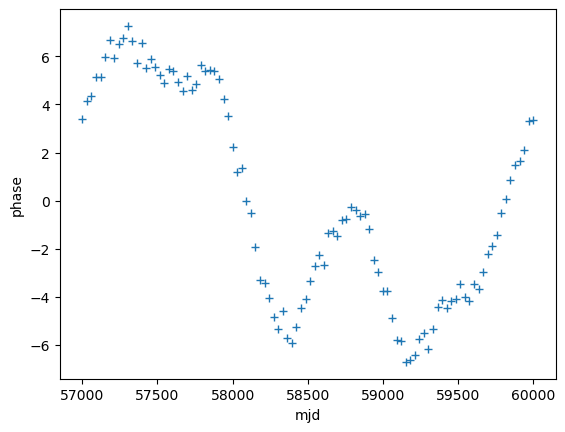

In [72]:
plt.errorbar(t.get_mjds(), ftr.resids.phase_resids, ls="", marker="+")
plt.ylabel("phase")
plt.xlabel("mjd")
plt.show()

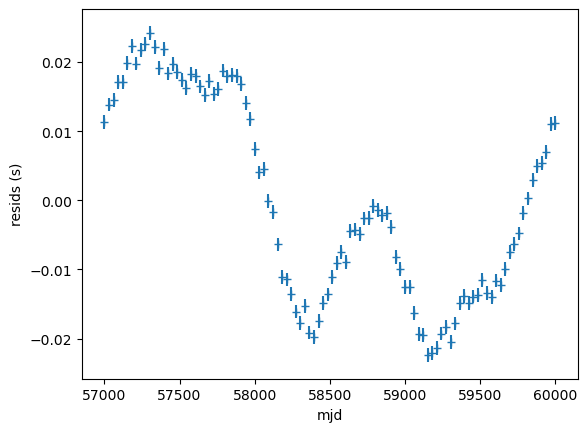

In [73]:
plt.errorbar(t.get_mjds(), ftr.resids.time_resids, ftr.resids.get_data_error(), ls="", marker="+")
plt.ylabel("resids (s)")
plt.xlabel("mjd")
plt.show()

In [75]:
def powlaw(x, a, b) :
    return a * np.power(x, b)

def get_amp_ind(residuals,nwaves,res_type=None,show_plot=False):
    if res_type == 'time':
        residuals = residuals.time_resids.to(u.s) # Are units supposed to be in seconds or days
        title=f'FFT of Time Residuals'                  # Days gets me in the estimated values 
    if res_type == 'phase':
        residuals = residuals.phase_resids
        title=f'FFT of Phase Residuals'
    a = np.fft.fft(residuals.astype(np.float64))
    psd = np.abs(a)**2 # The units of the power spectral density should be amp_units**2 / sampling frequency
    freqs = np.fft.fftfreq(len(psd),d=1/(2*len(psd)))
    lim = int(len(psd)/2)
    xdata = freqs[1:nwaves+1]
    ydata = psd[1:nwaves+1]

    popt,pcov = op.curve_fit(powlaw,xdata,ydata,maxfev=1000)
    log.info(f'The Amp is {popt[0]} and the spectral index is {popt[1]}')
    log.info(f'The reporting convection is: logA is {np.log10(popt[0])} and the spectral index is {-popt[1]}')
    if show_plot:

        plt.figure(figsize=(15,10))
        plt.plot(freqs[1:lim], popt[0]*np.power(freqs[1:lim],popt[1]),'--',label='Power-law Fit')
        plt.plot(freqs[1:lim],psd[1:lim],'x')
        plt.title(f'{title}', fontsize = 24)
        plt.xscale('log')
        plt.yscale('log')
        plt.yticks(fontsize=16)
        plt.xticks(fontsize=16)
        plt.ylabel('Power Spectral Density (s$^2$)',fontsize = 16)
        plt.xlabel('Sample Frequency',fontsize = 16)
        plt.grid('True')
    
    return [np.log10(popt[0]),popt[1]]

In [76]:
residuals = pr.Residuals(t,m)
a = np.fft.fft(residuals.time_resids.to(u.s))
psd = np.abs(a)**2
freqs = np.fft.fftfreq(len(psd),d=1/(2*len(psd)))
lim = int(len(psd)/2)
xdata = freqs[1:11]
ydata = psd[1:11].value

In [77]:
psd

<Quantity [6.93858373e-18, 8.74048001e-01, 1.34166405e-01, 6.04340854e-02,
           5.20783100e-02, 5.95676260e-04, 3.24831220e-03, 9.37959238e-04,
           2.96707071e-04, 3.39503440e-04, 3.04025181e-04, 3.73843977e-05,
           2.03388361e-04, 2.18751213e-04, 4.54946725e-05, 1.24363830e-04,
           2.03692642e-04, 1.05874704e-04, 2.56648930e-05, 3.91617849e-04,
           1.11312695e-04, 9.42531616e-05, 2.67583703e-05, 2.30916427e-04,
           4.65648766e-05, 1.99735199e-04, 4.86146762e-04, 4.40571469e-05,
           1.55126959e-04, 3.60443824e-04, 5.51227900e-06, 1.12813488e-04,
           2.13759280e-04, 1.56342832e-04, 4.32102641e-06, 1.85148469e-04,
           2.26088111e-06, 2.01360032e-04, 2.90410846e-05, 2.87938651e-04,
           9.08199071e-05, 3.44810022e-04, 4.02765364e-05, 3.56113685e-05,
           6.75403121e-05, 1.45184245e-04, 6.52540347e-05, 9.38772948e-07,
           1.42325740e-04, 2.02966844e-05, 8.76497177e-06, 2.02966844e-05,
           1.42325740e-04

array([0.87340085, 0.1444258 , 0.05040299, 0.02388229, 0.01338033,
       0.00833465, 0.00558563, 0.00394918, 0.0029087 , 0.00221258])

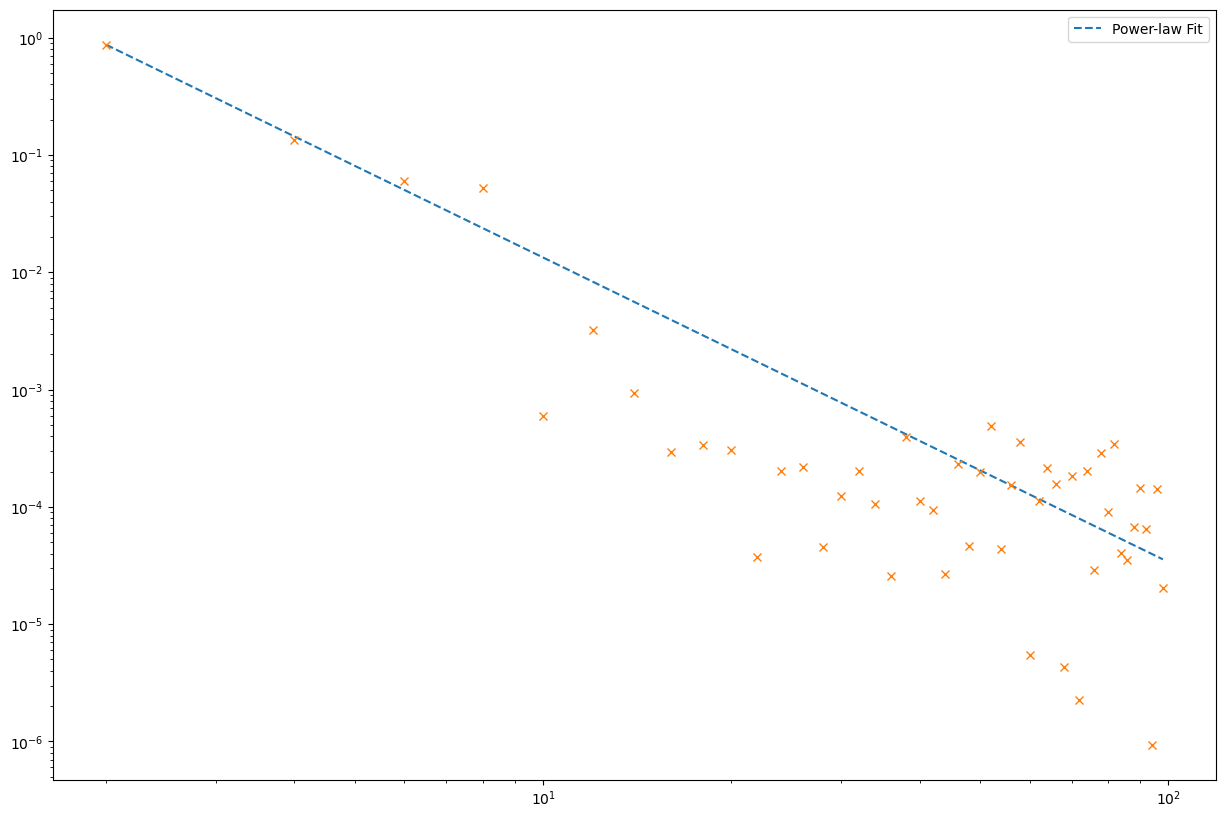

In [78]:
def loss(params):
    a,b = params
    y_pred = powlaw(xdata,a,b)
    return np.sum((ydata-y_pred)**2)

initial_guess = [-12,0]

result = op.minimize(loss, initial_guess)
y_pred = powlaw(xdata,result.x[0],result.x[1])
ssr = np.sum((ydata - y_pred)**2)
df = len(xdata)-len(initial_guess)
mse = ssr/df
plt.figure(figsize=(15,10))
plt.plot(freqs[1:lim], result.x[0]*np.power(freqs[1:lim],result.x[1]),'--',label='Power-law Fit')
plt.plot(freqs[1:lim],psd[1:lim],'x')
plt.xscale('log')
plt.yscale('log')
plt.legend()
result.x[0]*np.power(xdata,result.x[1])

In [50]:
result.x

array([ 6.32482788, -5.05861334])

In [29]:
def designmatrix(mjds,nwaves,setpoint,F0):
    ndata = len(mjds)
    Tobs = (mjds[-1]-mjds[0]).to_value(u.yr)
    tnscale = (2/Tobs)**0.5 * F0.quantity
    freqs = np.linspace(1/Tobs,nwaves/Tobs,nwaves)*1/u.yr
    F = np.empty([ndata,2*nwaves],dtype=np.float64)
    phase= np.empty_like(mjds.value)
    times = (((mjds.value - setpoint)/365.25)*u.yr)
    #times = (mjds + extended - setpoint)/365.25 ? do I need to extend dt as well?
    for iharm, freq in enumerate(freqs):
        phase[:] = (2*np.pi*freq*times)
        np.cos(phase,out=F[:,2*iharm])
        np.sin(phase,out=F[:,2*iharm+1])
    F *= tnscale.value 
    F *= tnscale.unit
    return freqs, F, Tobs, times, tnscale

def lst_squares_fit(model,ts,residuals,nwaves):
    mjds = ts.get_mjds()
    phase_res = residuals.phase_resids.astype(np.float64)
#     phase_res= residuals.time_resids.to(u.s).astype(np.float64)
    
    freqs, F, Tobs, times, tnscale = designmatrix(mjds,nwaves,model.PEPOCH.value,model.F0)
    
    coeffs, fit_res, _, _ = np.linalg.lstsq(F,phase_res,rcond=None)
    cos_coeffs, sin_coeffs = np.asarray(coeffs[::2]), np.asarray(coeffs[1::2])
    
    log.info(f'The residual of the lstsq fit between the Fourier matrix and the simulated rednoise is: {fit_res}')
    
    return coeffs

def plot_waves(mjds,coeffs,model,nmodes,plot=True,single_waves=False):
    dt = ((mjds.value - model.PEPOCH.value)*mjds.unit).to(u.yr)
    Tobs = (mjds[-1]-mjds[0]).to(u.yr)
    freqs = np.linspace(1/Tobs,nmodes/Tobs,nmodes) 
#     cos_coeffs, sin_coeffs = np.asarray(coeffs[::2]), np.asarray(coeffs[1::2])
    cos_coeffs, sin_coeffs = coeffs[::2], coeffs[1::2]
    fmat_wave = np.zeros(len(dt))*coeffs.unit
    if plot:
        plt.figure(figsize=(10,5))
        plt.yticks(fontsize=16)
        plt.xticks(fontsize=16)
        plt.ylabel('Time Residuals (s)',fontsize = 16)
        plt.xlabel('MJD (d)',fontsize = 16)
        plt.grid('True')
        for i in range(len(cos_coeffs)):
            wave = cos_coeffs[i]*np.cos((2*np.pi*freqs[i]*dt).value)+sin_coeffs[i]*np.sin((2*np.pi*freqs[i]*dt).value)
            fmat_wave += wave
            if single_waves:
                plt.title('Waves using Fourier Matrix coefficients', fontsize = 24)
                plt.plot(mjds,wave, label=f'Wave {i}')
        if not single_waves:
            plt.title('Summed Wave using Fourier Matrix coefficients', fontsize = 24)
            plt.plot(mjds,fmat_wave,'+',label='Fourier Matrix Summed Wave')
            
    return fmat_wave

mjds = t.get_mjds()
nwaves = 5
resids =pr.Residuals(t,m)

freqs, F, _ , _ , tnscale = designmatrix(mjds,nwaves,m.PEPOCH.value,m.F0)
fcoeffs = lst_squares_fit(m,t,resids,nwaves)
fcoeffs
fcoeffs.unit

Unit("1 / Hz")

In [30]:
amp = [fcoeffs[0]**2+fcoeffs[1]**2,fcoeffs[2]**2+fcoeffs[3]**2]#,fcoeffs[2]**2+fcoeffs[3]**2
print(amp[0],amp[1].decompose())

7.597183170149748e-08 1 / Hz2 5.395302226099977e-09 s2


[-3.1828621588732964, -3.8333716660743966]

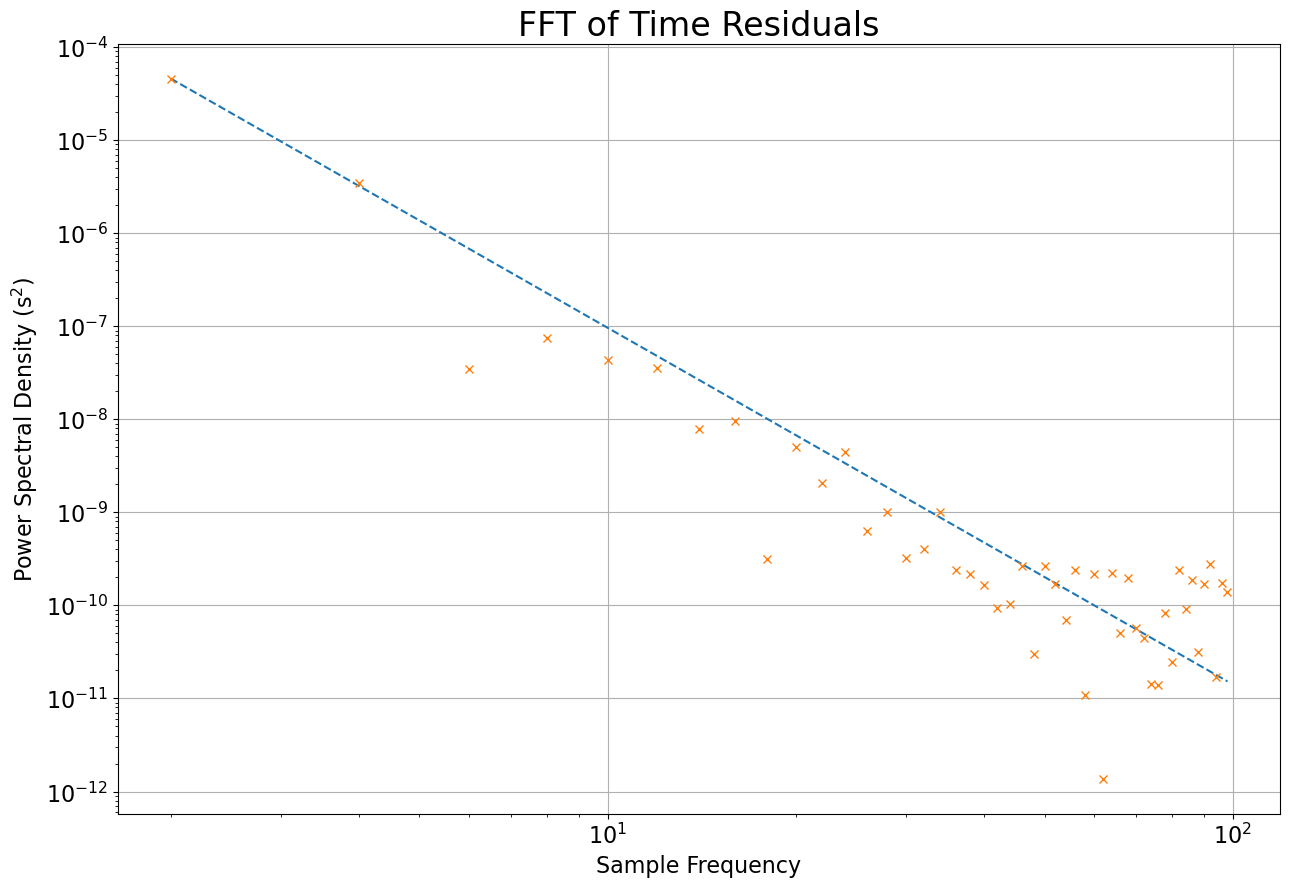

In [31]:
nwaves = 5
get_amp_ind(resids,nwaves,res_type='time',show_plot=True)
# a = np.fft.rfft(resids.time_resids)
# psd = np.abs(a)**2
# freqs = np.fft.fftfreq(len(psd),d=1/(2*len(psd)))
# lim = int(len(psd)/2)
# xdata = freqs[1:nwaves+1]
# ydata = psd[1:nwaves+1]
# popt,pcov = op.curve_fit(powlaw,xdata,ydata,maxfev=1000)
# # plt.scatter(xdata,ydata)
# # xdata
# popt

In [ ]:
# fmat = plot_waves(mjds,fcoeffs,m,nwaves)
# print(fmat.unit)

In [ ]:
# Note: This designmatrix function and the only in TNMatrix are transpose of each other
# def designmatrix(mjds,nwaves,setpoint,F0,extended=0):
#     ndata = len(mjds)
#     Tobs = (mjds[-1]-mjds[0]+extended)
#     tnscale = (2/Tobs)**0.5 * F0
#     freqs = np.linspace(1/Tobs,nwaves/Tobs,nwaves)
#     F = np.empty([ndata,2*nwaves],dtype=np.float64)
#     phase= np.empty_like(mjds)
#     times = (mjds - setpoint)/365.25 
#     #times = (mjds + extended - setpoint)/365.25 ? do I need to extend dt as well?
#     for iharm, freq in enumerate(freqs):
#         phase[:] = (2*np.pi*freq)*times
#         np.cos(phase,out=F[:,2*iharm])
#         np.sin(phase,out=F[:,2*iharm+1])
#     F *= tnscale
#     return freqs, F, Tobs, times, tnscale


# def lst_squares_fit(model,ts,residuals,nwaves,extended=0):
#     mjds = ts.get_mjds().value
#     phase_res = residuals.phase_resids.astype(np.float64)
# #     phase_res= residuals.time_resids.to_value(u.s).astype(np.float64)
    
#     freqs, F, Tobs, times, tnscale = designmatrix(mjds,nwaves,model.PEPOCH.value,model.F0.value,extended)
    
#     coeffs, fit_res, _, _ = np.linalg.lstsq(F,phase_res,rcond=None)
#     cos_coeffs, sin_coeffs = np.asarray(coeffs[::2]), np.asarray(coeffs[1::2])
    
#     log.info(f'The residual of the lstsq fit between the Fourier matrix and the simulated rednoise is: {fit_res}')
    
#     return coeffs

# def plot_waves(mjds,coeffs,model,nmodes,plot=True,single_waves=False):
#     dt = (mjds.value - model.PEPOCH.value)/365.25
#     Tobs = (mjds[-1].value-mjds[0].value)/365.25
#     freqs = np.linspace(1/Tobs,nmodes/Tobs,nmodes) 
#     cos_coeffs, sin_coeffs = np.asarray(coeffs[::2]), np.asarray(coeffs[1::2])
#     fmat_wave = np.zeros(len(dt))
#     if plot:
#         plt.figure(figsize=(10,5))
#         plt.yticks(fontsize=16)
#         plt.xticks(fontsize=16)
#         plt.ylabel('Phase',fontsize = 16)
#         plt.xlabel('MJD (d)',fontsize = 16)
#         plt.grid('True')
#         for i in range(len(cos_coeffs)):
#             wave = cos_coeffs[i]*np.cos(2*np.pi*freqs[i]*dt)+sin_coeffs[i]*np.sin(2*np.pi*freqs[i]*dt)
#             fmat_wave += wave
#             if single_waves:
#                 plt.title('Waves using Fourier Matrix coefficients', fontsize = 24)
#                 plt.plot(mjds,wave, label=f'Wave {i}')
#         if not single_waves:
#             plt.title('Summed Wave using Fourier Matrix coefficients', fontsize = 24)
#             plt.plot(mjds,fmat_wave,'+',label='Fourier Matrix Summed Wave')
            
#     return fmat_wave

In [32]:
nwaves = 3
resids = pr.Residuals(t,m)

fcoeffs = lst_squares_fit(m,t,resids,nwaves)

# fcoeffs = fcoeffs /2 # Why do I need to divide by 2 here but multiply by 2 in my gamma-ray toas

In [33]:
mjds = t.get_mjds()
freqs, F, _ , _ , _ = designmatrix(mjds,nwaves,m.PEPOCH.value,m.F0)
np.linalg.lstsq(F,resids.phase_resids.astype(np.float64),rcond=None)

(<Quantity [ 2.75261843e-04,  4.37199457e-06,  5.94675283e-05,
            -4.35712366e-05, -3.83578702e-06,  7.67708992e-06] 1 / Hz>,
 <Quantity [3.50027395e-06]>,
 6,
 <Quantity [107.26311107, 104.1533725 , 104.1533725 , 104.15337249,
            104.15337248, 104.15337247] Hz>)

In [ ]:
# fmat = plot_waves(mjds,fcoeffs/2,m,nwaves)
# plt.plot(t.get_mjds(), ftr.resids.time_resids, ls="", marker="+", label='Residuals')
# # plt.plot(t.get_mjds(), fmat*m.F0.value, ls="", marker="+",label='Adjusted coefficients')
# plt.legend()

In [ ]:
# m = get_model(
#    StringIO(
#         """
#         RAJ    		05:00:00
#         DECJ   		20:00:00
#         F0     		30     1 
#         F1     		-1e-14  1
#         PEPOCH 		58500
#         #DM     		15
#         #EFAC tel gbt 	1.3
#         TNRedAmp 	-12
#         TNRedGam 	4.0
#         TNRedC 		30
#         """	
#     )
# )

# cos_coeffs, sin_coeffs = fcoeffs[::2], fcoeffs[1::2]
# tobs = (t.last_MJD.value - t.first_MJD.value)/365.25
# tn_scale = (2/tobs)**0.5 * m.F0.value # Units are wacky

# cos_coeffs = cos_coeffs*tn_scale/m.F0.value
# sin_coeffs= sin_coeffs*tn_scale/m.F0.value


# wave_model = models.wave.Wave()
# wave_model.remove_param('WAVE1')
# wave_model.WAVE_OM.quantity = 2*np.pi/(t.last_MJD-t.first_MJD)
# wave_model.WAVE_OM.uncertainty = 0.0
# wave_model.WAVEEPOCH.quantity = m.PEPOCH.quantity
# for i in range(nwaves):
#     wave_model.add_param(pp.prefixParameter(name=f'WAVE{i+1}',value=[-sin_coeffs[i],-cos_coeffs[i]],type_match='pair',parameter_type='pair',long_double=True,units=u.s))

# m.add_component(wave_model)

# mjds = t.get_mjds().value
# res = pr.Residuals(t,m)
# plt.figure(figsize=(15,10))
# plt.plot(mjds,res.phase_resids,'x',label='Waves Added in Model')
# plt.plot(mjds,ftr.resids.time_resids,'+',label='Original Residuals')
# plt.title('Prefit Phase Residuals + Design Matrix waves', fontsize = 24)
# plt.yticks(fontsize=16)
# plt.xticks(fontsize=16)
# plt.ylabel('Residuals',fontsize = 16)
# plt.xlabel('MJDs',fontsize = 16)
# plt.grid('True')
# plt.legend(fontsize=16)
# plt.show()

In [34]:
class TNMatrix(object):
    """ Encapsulate the spectral decomposition form of a TN process."""
    def __init__(self,p,freqs,model,ts,zeropad=None):
        """ NB freqs should be in cycles/year!."""
        self.freqs = freqs
        n = zeropad + 2*len(freqs)
        self._H = np.zeros((n,n),dtype=float)
        x,y = np.diag_indices_from(self._H)
        self._x = x[zeropad:]
        self._y = y[zeropad:]
        self.update_p(p)

        self.model = model
#         self.epoch = model.WAVEEPOCH.value if model.WAVEEPOCH else model.PEPOCH.value
        self.epoch = model.PEPOCH.value
        self.mjds = ts.get_mjds().value
        self.scale = (2/(self.mjds[-1]-self.mjds[0])/365.25)**0.5*self.model.F0.quantity # Units of Hz

    def designmatrix(self):
        ndata = len(self.mjds)
        nharm = len(self.freqs)
        F = np.empty([2*nharm,ndata],dtype=np.float128)
        phase = np.empty_like(self.mjds)
        times = (self.mjds-self.epoch)/365.25 # This is in years now
        for iharm,freq in enumerate(self.freqs):
            phase[:] = (2*np.pi*freq)*times # Units should be freq (1/years) * times (years) to give units of phase
            np.cos(phase,out=F[2*iharm,:])
            np.sin(phase,out=F[2*iharm+1,:])
        F *= self.scale.value # Units for F should now be in Hz
#         F *= self.scale.unit
        return F
    
    def eval_pl(self,p,freqs):
        # Make sure that frequencies are in 1/year
        amp,alpha = p
#         amp = amp**2
        return (10**amp)*freqs**-alpha
    
    def get_values(self):
        return self.coeffs
    
    def H(self):
        """ Return inverse covariance matrix."""
        return self._H
    
    def update_p(self,p):
        freqs = self.freqs * 365.25 # *24*3600 # Frequencies are converted into 1/d
#         freqs = self.freqs
        tn_vals = 2./self.eval_pl(p,freqs) 
        self._H[self._x[::2],self._y[::2]] = tn_vals
        self._H[self._x[1::2],self._y[1::2]] = tn_vals
        self._p = p

In [43]:
def joint_designmatrix(model,ts,H_tn=None):
#     mjds = ts.get_mjds().value

    D, params, units = model.designmatrix(ts)
    D *= -model.F0.value
    D = D.transpose()

    if H_tn:
        F = H_tn.designmatrix()
        freqs = H_tn.freqs
        output = np.empty((D.shape[0]+F.shape[0],D.shape[1]),dtype=np.float64)
        output[:D.shape[0]]=D
        output[D.shape[0]:]=F
        return output, F.T, freqs
    
    return D, None, None

def update_model(model,coeffs):
    for i,k in enumerate(model.free_params):
        getattr(model,k).value += coeffs[i+1]
    return model
    

def fit_tn_tm_model(model,ts,p,nwaves,niter=2,offset=0.0,eff_wn=0.01,target_phase=0.5,extended=0,coeffs=None,H_tn=None):
    '''
    Do stuff
    '''
    mjds = ts.get_mjds().value # Should be in value of days
    
    import copy
    model2 = copy.deepcopy(model)
        
    red_coeffs = np.zeros(2*nwaves,dtype=np.float64) if coeffs is None else coeffs
    
    residuals_post = []
    for i in range(niter):        
        fitvals = np.append(offset,[getattr(model,p).value for p in model.free_params])
        print(f'Here are the fitvals on iter {i}: {fitvals}')
        
        # Create timing noise power_law matrix and fourier designmatrix
        n_params = len(fitvals)
        M, F_matrix, freqs = joint_designmatrix(model,ts,H_tn=H_tn)
        
        # Calculating the residuals
#         tm_phase = model.phase(ts).frac.value
        tm_phase = model.phase(ts)
        tm_phase = (tm_phase[0]+tm_phase[1]).value
        tn_phase = np.inner(F_matrix,red_coeffs)
        resid = target_phase-(tn_phase+tm_phase)
        get_values = np.append(fitvals,red_coeffs)
        
        # Linear Algebra time
        if eff_wn is not None:
            Hw = np.diag(np.ones(len(resid))/eff_wn**2)
            T = Hw@M.T
            H = M@T
            X = resid@T
        else:
            H = M@M.T
            X = resid@M.T
        if H_tn is not None:
            H += H_tn.H()
            X -= np.inner(H_tn.H(),get_values)
        
        scale = np.diag(H)**-0.5
        Hscale = H*np.outer(scale,scale)
        Xscale = X*scale
        
        try:
            c = cho_factor(Hscale,lower=True)
        except LinAlgError:
            print('Inverting initial hessian failed')
            Hscale += np.diag(np.diag(Hscale)*1e-3)
            c = cho_factor(Hscale,lower=True)
            
        coeffs = cho_solve(c,Xscale)*scale
        print(f'Here are the postfit shifts for iter {i}: {coeffs}')
        # Calculate new residuals to check for improvement
        model = update_model(model,coeffs)
        red_coeffs = coeffs[n_params:]
#         freqs, F_matrix, Tobs, dt, tnscale = designmatrix(mjds,nwaves,model.PEPOCH.value,model.F0.value,extended)
        M, F_matrix, freqs = joint_designmatrix(model,ts,H_tn=H_tn)
#         tm_phase = model.phase(ts).frac.value
        tm_phase = model.phase(ts)
        tm_phase = (tm_phase[0]+tm_phase[1]).value
        tn_phase = np.inner(F_matrix,red_coeffs)
        resid = target_phase-(tn_phase+tm_phase)
        offset -= np.median(resid)
        residuals_post.append(resid)
        
    M, F_matrix, freqs = joint_designmatrix(model,ts,H_tn=H_tn)
#     tm_phase=model.phase(ts).frac.value
    tm_phase = model.phase(ts)
    tm_phase = (tm_phase[0]+tm_phase[1]).value
    tn_phase = np.inner(F_matrix,red_coeffs)
    resid = target_phase-(tn_phase+tm_phase)
    
    if np.max(np.abs(resid)) > 0.05:
        print(f'The deviation (max = {np.max(np.abs(resid)):.2f}, std = {np.std(np.abs(resid)):.2f}) in phase between the original model and the resulting fit is too large to return a good fit model')
        
    return coeffs, resid, freqs, residuals_post, model2

def coeffs_to_wave_coeffs(coeffs):
    cos_coeffs, sin_coeffs = np.asarray(coeffs[::2]), np.asarray(coeffs[1::2])
    return cos_coeffs, sin_coeffs


In [44]:
Tobs = (mjds[-1]-mjds[0]).to_value(u.yr)
freqs = np.linspace(1/Tobs,nwaves/Tobs,nwaves)

m = get_model(
   StringIO(
        """
        RAJ    		05:00:00
        DECJ   		20:00:00
        F0     		30     1 
        F1     		-1e-14  1
        PEPOCH 		58500
        #DM     		15
        #EFAC tel gbt 	1.3
        TNRedAmp 	-6
        TNRedGam 	4.0
        TNRedC 		30
        """	
    )
)

p_p = [-13,4.0]
zeropad = len(m.free_params)+1
n_params = zeropad
H_tn = TNMatrix(p_p,freqs,m,t,zeropad=zeropad)

In [45]:
t.compute_pulse_numbers(m)
target_phase=t.get_pulse_numbers()
coeffs,post_residuals,freqs, fit_resids, m2 = fit_tn_tm_model(m,t,p_p,nwaves,eff_wn=None,offset=-1.0,target_phase=target_phase,extended=0,coeffs=fcoeffs.value,H_tn=H_tn)

Here are the fitvals on iter 0: [-1.e+00  3.e+01 -1.e-14]
Here are the postfit shifts for iter 0: [ 7.59734654e-02 -2.91033851e-12  1.01714442e-18 -2.75261843e-04
 -4.37199457e-06 -5.94675283e-05  4.35712366e-05  3.83578702e-06
 -7.67708992e-06]
Here are the fitvals on iter 1: [-9.24247296e-01  3.00000000e+01 -9.99898286e-15]
Here are the postfit shifts for iter 1: [ 7.59764037e-02  1.41037317e-19  2.65804156e-27  2.75261843e-04
  4.37199457e-06  5.94675283e-05 -4.35712366e-05 -3.83578702e-06
  7.67708992e-06]
The deviation (max = 0.08, std = 0.00) in phase between the original model and the resulting fit is too large to return a good fit model


In [46]:
coeffs[n_params:]

array([ 2.75261843e-04,  4.37199457e-06,  5.94675283e-05, -4.35712366e-05,
       -3.83578702e-06,  7.67708992e-06])

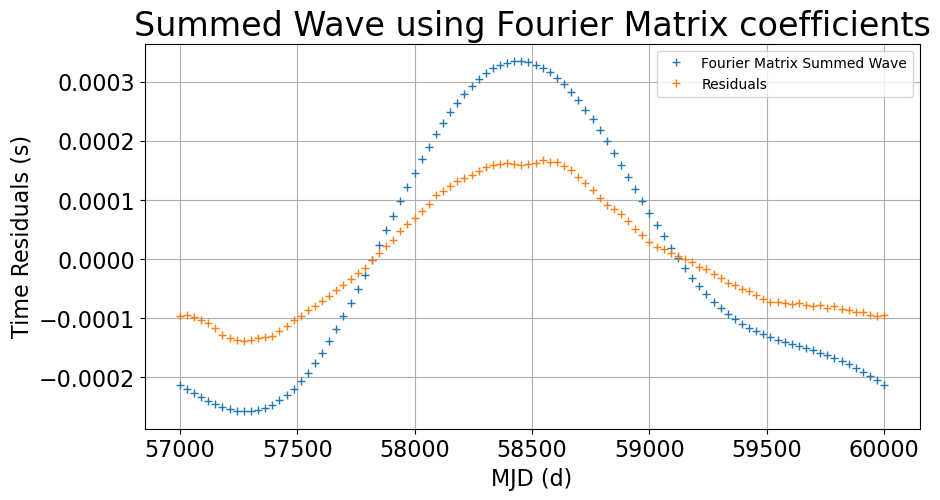

In [49]:
# for i in range(len(fit_resids)):
#     plt.plot(fit_resids[i])

fmat = plot_waves(mjds,coeffs[n_params:]*u.s,m,nwaves)
# fmat = plot_waves(mjds,fcoeffs*u.s,m,nwaves)
plt.plot(t.get_mjds(), ftr.resids.time_resids, ls="", marker="+", label='Residuals')
plt.legend()

In [ ]:
print(m2.compare(m))

In [ ]:
iter1_sfitvals = np.append(-1.0,[getattr(m,p).value for p in m.free_params])
n_params = len(iter1_sfitvals)
p_p = [-13,-4.0]
zeropad = len(m.free_params)+1
iter1_sH_tn = TNMatrix(p_p,freqs,m,t,zeropad=zeropad)
iter1_sM, iter1_sF_matrix, freqs = joint_designmatrix(m,t,H_tn=iter1_sH_tn)
iter1_sred_coeffs = fcoeffs.value # is in s
target_phase = t.get_pulse_numbers().value

iter1_stm_phase = m.phase(t)
iter1_stm_phase = (iter1_stm_phase[0]+iter1_stm_phase[1]).value
iter1_stn_phase = np.inner(iter1_sF_matrix,iter1_sred_coeffs)
iter1_sresid = target_phase-(iter1_stn_phase+iter1_stm_phase)
iter1_sget_values = np.append(iter1_sfitvals,iter1_sred_coeffs)

In [ ]:
iter1_sget_values

In [ ]:
plt.plot(iter1_sresid)

In [ ]:
# eff_wn = None
# if eff_wn is not None:
#     Hw = np.diag(np.ones(len(resid))/eff_wn**2)
#     T = Hw@iter1_sM.T
#     H = iter1_sM@T
#     X = resid@T
# else:
H = iter1_sM@iter1_sM.T
X = iter1_sresid@iter1_sM.T
# if iter1_sH_tn is not None:
H += iter1_sH_tn.H()
X -= np.inner(iter1_sH_tn.H(),iter1_sget_values)
        
scale = np.diag(H)**-0.5
Hscale = H*np.outer(scale,scale)
Xscale = X*scale
        
try:
    c = cho_factor(Hscale,lower=True)
except LinAlgError:
    print('Inverting initial hessian failed')
    Hscale += np.diag(np.diag(Hscale)*1e-3)
    c = cho_factor(Hscale,lower=True)
    
coeffs = cho_solve(c,Xscale)*scale
print(coeffs)
print(f'The difference between the starting fit values and cho_solve values is: \n{coeffs - iter1_sget_values}')

In [ ]:
import copy
iter1_m = copy.deepcopy(m)

In [ ]:
update_model(iter1_m,coeffs)

In [ ]:
iter1_ered_coeffs = coeffs[n_params:]
iter1_eH_tn = TNMatrix(p_p,freqs,iter1_m,t,zeropad=zeropad)
iter1_eM, iter1_eF_matrix, freqs = joint_designmatrix(iter1_m,t,H_tn=iter1_eH_tn)
iter1_etm_phase = iter1_m.phase(t)
iter1_etm_phase = (iter1_etm_phase[0]+iter1_etm_phase[1]).value
iter1_etn_phase = np.inner(iter1_eF_matrix,iter1_ered_coeffs)
iter1_eresid = target_phase-(iter1_etn_phase+iter1_etm_phase)
iter1_eoffset = -1.0 - np.median(iter1_eresid)

In [ ]:
plt.plot(iter1_eresid)

In [ ]:
iter1_eoffset

In [ ]:
# New iteration with the new offset and the updated model
iter2_sfitvals = np.append(iter1_eoffset,[getattr(iter1_m,p).value for p in iter1_m.free_params])
iter2_sH_tn = TNMatrix(p_p,freqs,iter1_m,t,zeropad=zeropad)
iter2_sM, iter2_sF_matrix, freqs = joint_designmatrix(iter1_m,t,H_tn=iter2_sH_tn)
target_phase = t.get_pulse_numbers().value

iter2_stm_phase = iter1_m.phase(t)
iter2_stm_phase = (iter2_stm_phase[0]+iter2_stm_phase[1]).value
iter2_stn_phase = np.inner(iter2_sF_matrix,iter1_ered_coeffs)
iter2_sresid = target_phase-(iter2_stn_phase+iter2_stm_phase)
iter2_sget_values = np.append(iter2_sfitvals,iter1_ered_coeffs)

In [ ]:
print(iter2_sget_values)
plt.plot(iter2_sresid-iter1_eresid)

In [ ]:
# eff_wn = None
# if eff_wn is not None:
#     Hw = np.diag(np.ones(len(iter2_sresid))/eff_wn**2)
#     T = Hw@iter2_sM.T
#     H = iter2_sM@T
#     X = iter2_sresid@T
# else:
H = iter2_sM@iter2_sM.T
X = iter2_sresid@iter2_sM.T
# if H_tn is not None:
H += iter2_sH_tn.H()
X -= np.inner(iter2_sH_tn.H(),iter2_sget_values)
        
scale = np.diag(H)**-0.5
Hscale = H*np.outer(scale,scale)
Xscale = X*scale
        
try:
    c = cho_factor(Hscale,lower=True)
except LinAlgError:
    print('Inverting initial hessian failed')
    Hscale += np.diag(np.diag(Hscale)*1e-3)
    c = cho_factor(Hscale,lower=True)
    
new_coeffs = cho_solve(c,Xscale)*scale

print(new_coeffs)
print(f'The fractional difference between the starting fit values and cho_solve values is: \n{(new_coeffs - iter2_sget_values)/new_coeffs}')

In [ ]:
iter2_m = copy.deepcopy(iter1_m)
update_model(iter2_m,new_coeffs)

iter2_ered_coeffs = coeffs[n_params:]
iter2_eH_tn = TNMatrix(p_p,freqs,iter2_m,t,zeropad=zeropad)
iter2_eM, iter2_eF_matrix, freqs = joint_designmatrix(iter2_m,t,H_tn=iter2_eH_tn)
iter2_etm_phase = iter2_m.phase(t)
iter2_etm_phase = (iter2_etm_phase[0]+iter2_etm_phase[1]).value
iter2_etn_phase = np.inner(iter2_eF_matrix,iter2_ered_coeffs)
iter2_eresid = target_phase-(iter2_etn_phase+iter2_etm_phase)
iter2_eoffset = iter1_eoffset- np.median(iter2_eresid)

In [ ]:
fcoeffs.value

In [ ]:
fmat = plot_waves(mjds,-iter2_ered_coeffs*u.s,iter2_m,nwaves)
plt.plot(t.get_mjds(), ftr.resids.time_resids, ls="", marker="+", label='Residuals')
plt.legend()